# Traffic Sign Classification with CNN and HOG + SVM

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [2]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [3]:
train_df = pd.read_csv('Datensatz/Train.csv')
test_df = pd.read_csv('Datensatz/Test.csv')

In [4]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [6]:
train_df['Path'] = train_df['Path'].apply(lambda x: 'Datensatz/' + x)
test_df['Path'] = test_df['Path'].apply(lambda x: 'Datensatz/' + x)

In [7]:
random.choice(train_df['Path'].tolist())

'Datensatz/Train/13/00013_00001_00026.png'

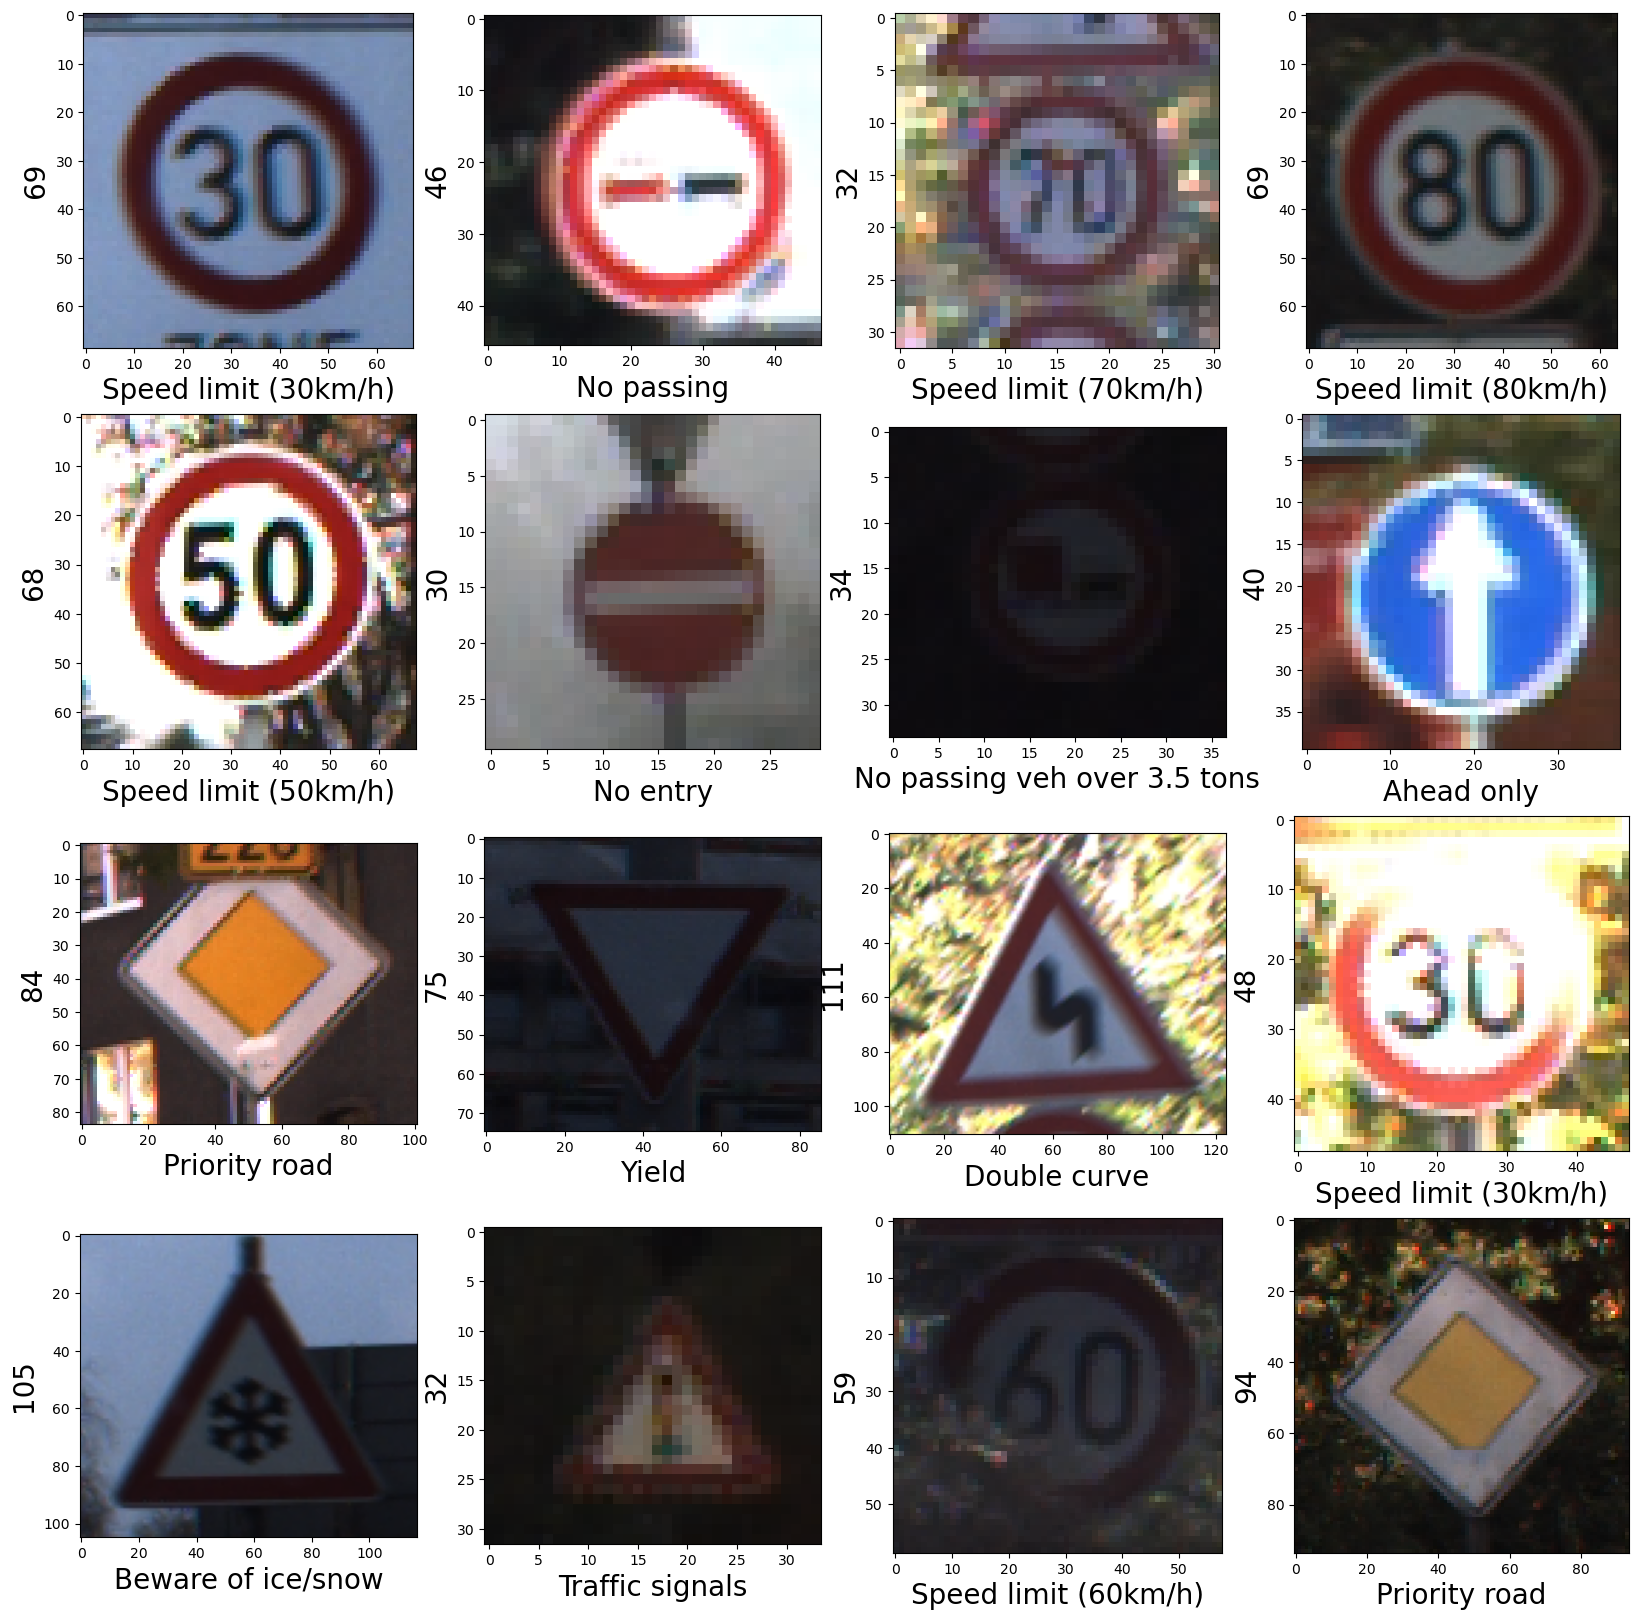

In [8]:
random_sample = train_df.sample(16)
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    img = plt.imread(random_sample['Path'].values.tolist()[i-1])
    plt.imshow(img)
    plt.grid(False)
    plt.xlabel(classes[random_sample['ClassId'].values.tolist()[i-1]], fontsize = 20)
    plt.ylabel(img.shape[0], fontsize = 20)
plt.savefig('random_sample.png', dpi=300)

## CNN

In [9]:
train_data = train_df.sample(frac=0.8,random_state=42)
val_data = train_df.drop(train_data.index)

NUM_CLASSES = len(classes)
IMG_SIZE = 32

def preprocess_image(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image/255
    return image

def load_data(data):
    X = []
    y = []
    for path, label in zip(data['Path'].values.tolist(), data['ClassId'].values.tolist()):
        image = cv2.imread(path)
        image = preprocess_image(image)
        X.append(image)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_data(train_data)
X_val, y_val = load_data(val_data)
X_test, y_test = load_data(test_df)

In [10]:
print(f'The shape of X_train : {X_train.shape}')
print(f'The shape of X_test : {y_train.shape}')

The shape of X_train : (31367, 32, 32, 3)
The shape of X_test : (31367,)


In [11]:
X_train

array([[[[0.15686275, 0.22352941, 0.41176471],
         [0.14901961, 0.21176471, 0.37254902],
         [0.1372549 , 0.2       , 0.30588235],
         ...,
         [0.17254902, 0.32941176, 0.54509804],
         [0.19607843, 0.34117647, 0.54509804],
         [0.2745098 , 0.44705882, 0.70588235]],

        [[0.18039216, 0.25882353, 0.41568627],
         [0.16078431, 0.23137255, 0.36078431],
         [0.13333333, 0.21176471, 0.34901961],
         ...,
         [0.09411765, 0.22745098, 0.37254902],
         [0.08627451, 0.20784314, 0.26666667],
         [0.12941176, 0.27843137, 0.36470588]],

        [[0.18431373, 0.2745098 , 0.44705882],
         [0.14509804, 0.25098039, 0.38039216],
         [0.11764706, 0.23529412, 0.39215686],
         ...,
         [0.10588235, 0.22745098, 0.35294118],
         [0.07843137, 0.20392157, 0.2627451 ],
         [0.08627451, 0.21960784, 0.29019608]],

        ...,

        [[0.12156863, 0.2       , 0.36862745],
         [0.14901961, 0.21568627, 0.36078431]

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Train on 31367 samples, validate on 7842 samples
Epoch 1/10
31367/31367 [==============================] - 11s 363us/step - loss: 1.8443 - accuracy: 0.4710 - val_loss: 0.4589 - val_accuracy: 0.8712
Epoch 2/10
31367/31367 [==============================] - 11s 355us/step - loss: 0.4090 - accuracy: 0.8736 - val_loss: 0.1409 - val_accuracy: 0.9596
Epoch 3/10
31367/31367 [==============================] - 11s 355us/step - loss: 0.2047 - accuracy: 0.9365 - val_loss: 0.0762 - val_accuracy: 0.9816
Epoch 4/10
31367/31367 [==============================] - 11s 354us/step - loss: 0.1342 - accuracy: 0.9598 - val_loss: 0.0633 - val_accuracy: 0.9833
Epoch 5/10
31367/31367 [==============================] - 11s 355us/step - loss: 0.1000 - accuracy: 0.9692 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 6/10
31367/31367 [==============================] - 11s 355us/step - loss: 0.0802 - accuracy: 0.9750 - val_loss: 0.0552 - val_accuracy: 0.9853
Epoch 7/10
31367/31367 [==============================] 

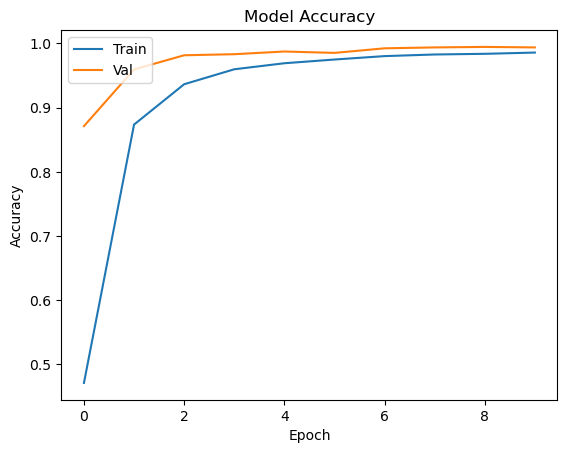

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('accuracy.png', dpi=300)
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
labels = test_df["ClassId"].values
print("Accuracy: ", model.evaluate(X_test, labels)[1])

12630/12630 [==============================] - 1s 100us/step
Accuracy:  0.9555819630622864


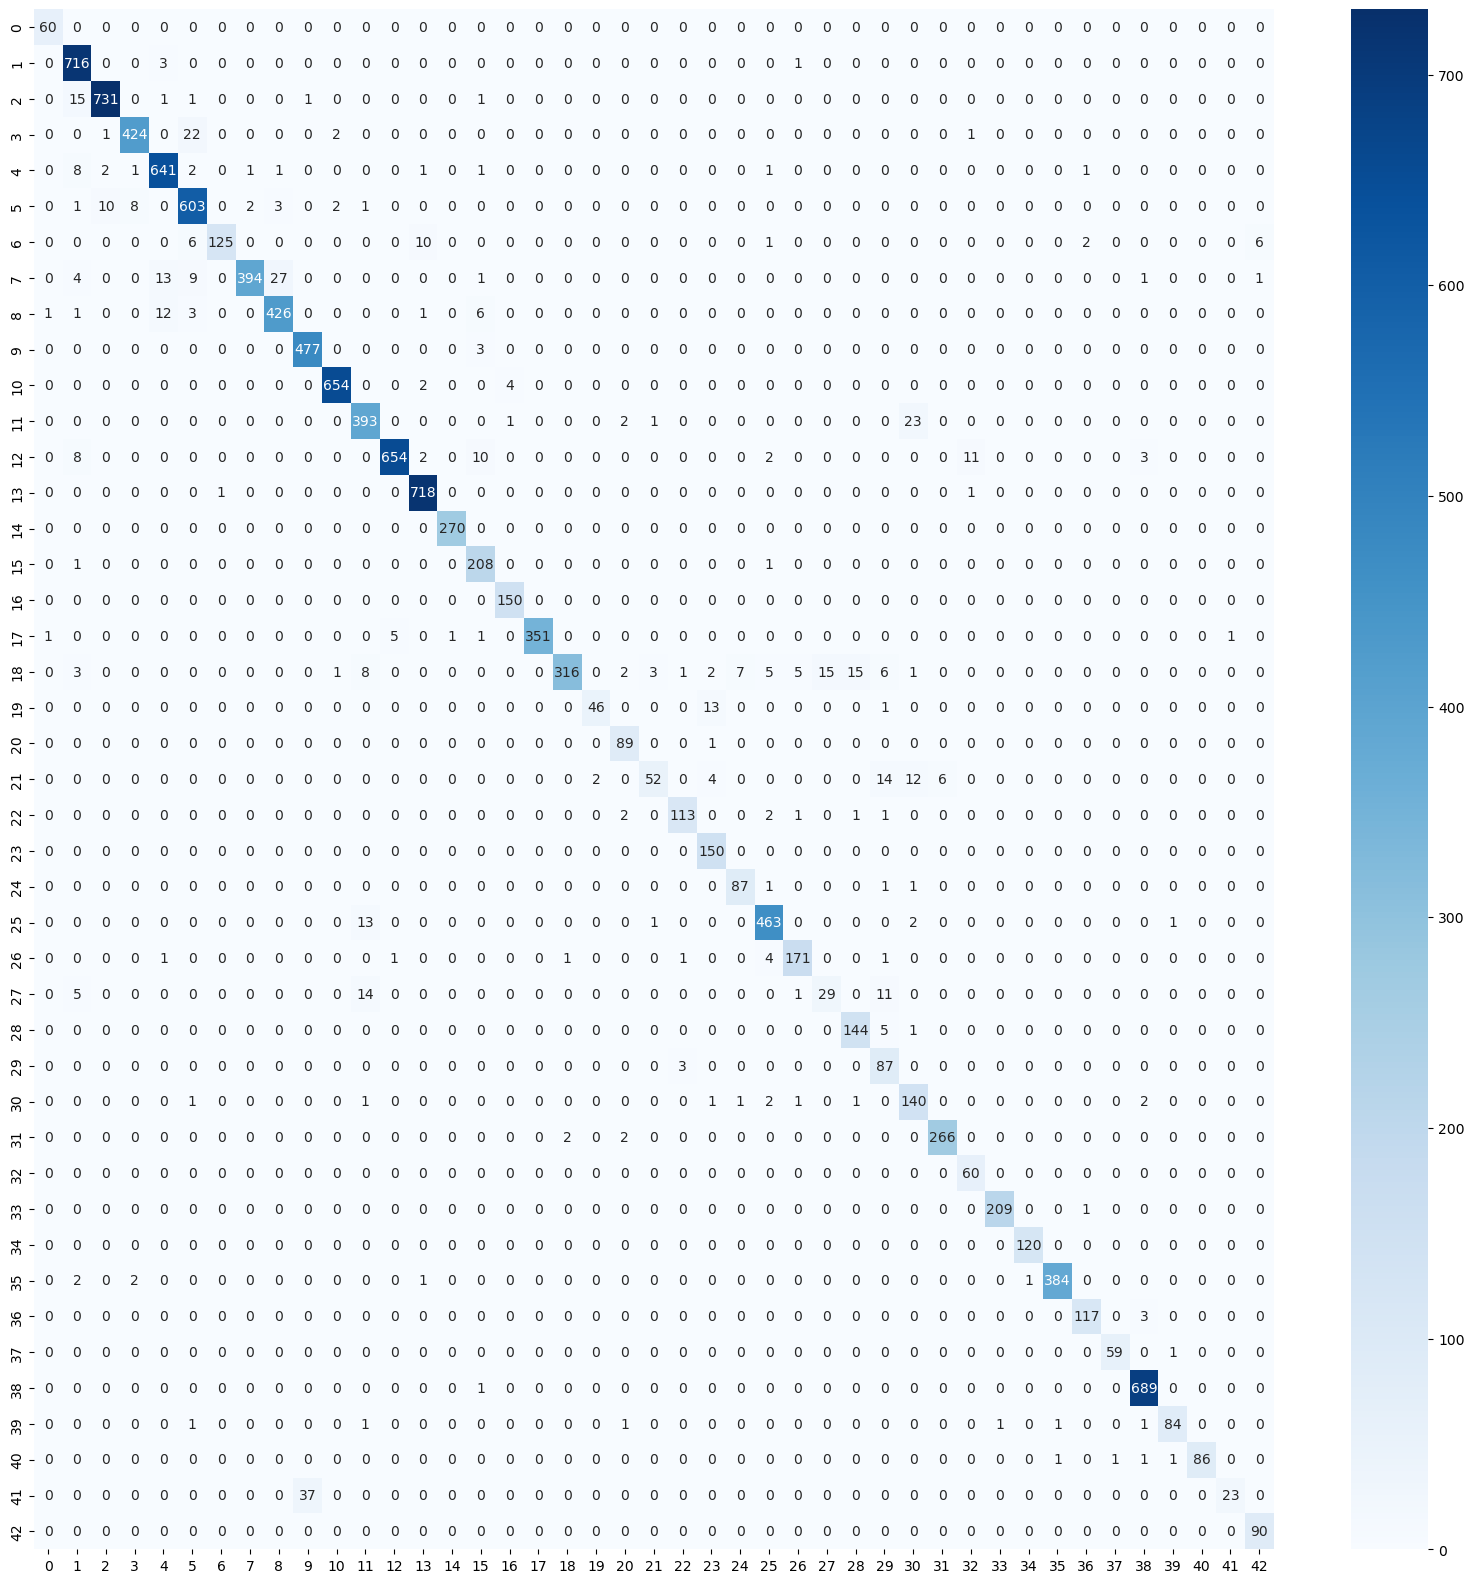

In [17]:
cm = confusion_matrix(labels, y_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.savefig('confusion_matrix_cnn.png', dpi=300)

In [18]:
true_pred = np.where(y_pred_classes == labels)[0]
print("Number of true predictions = ", len(true_pred))

Number of true predictions =  12069


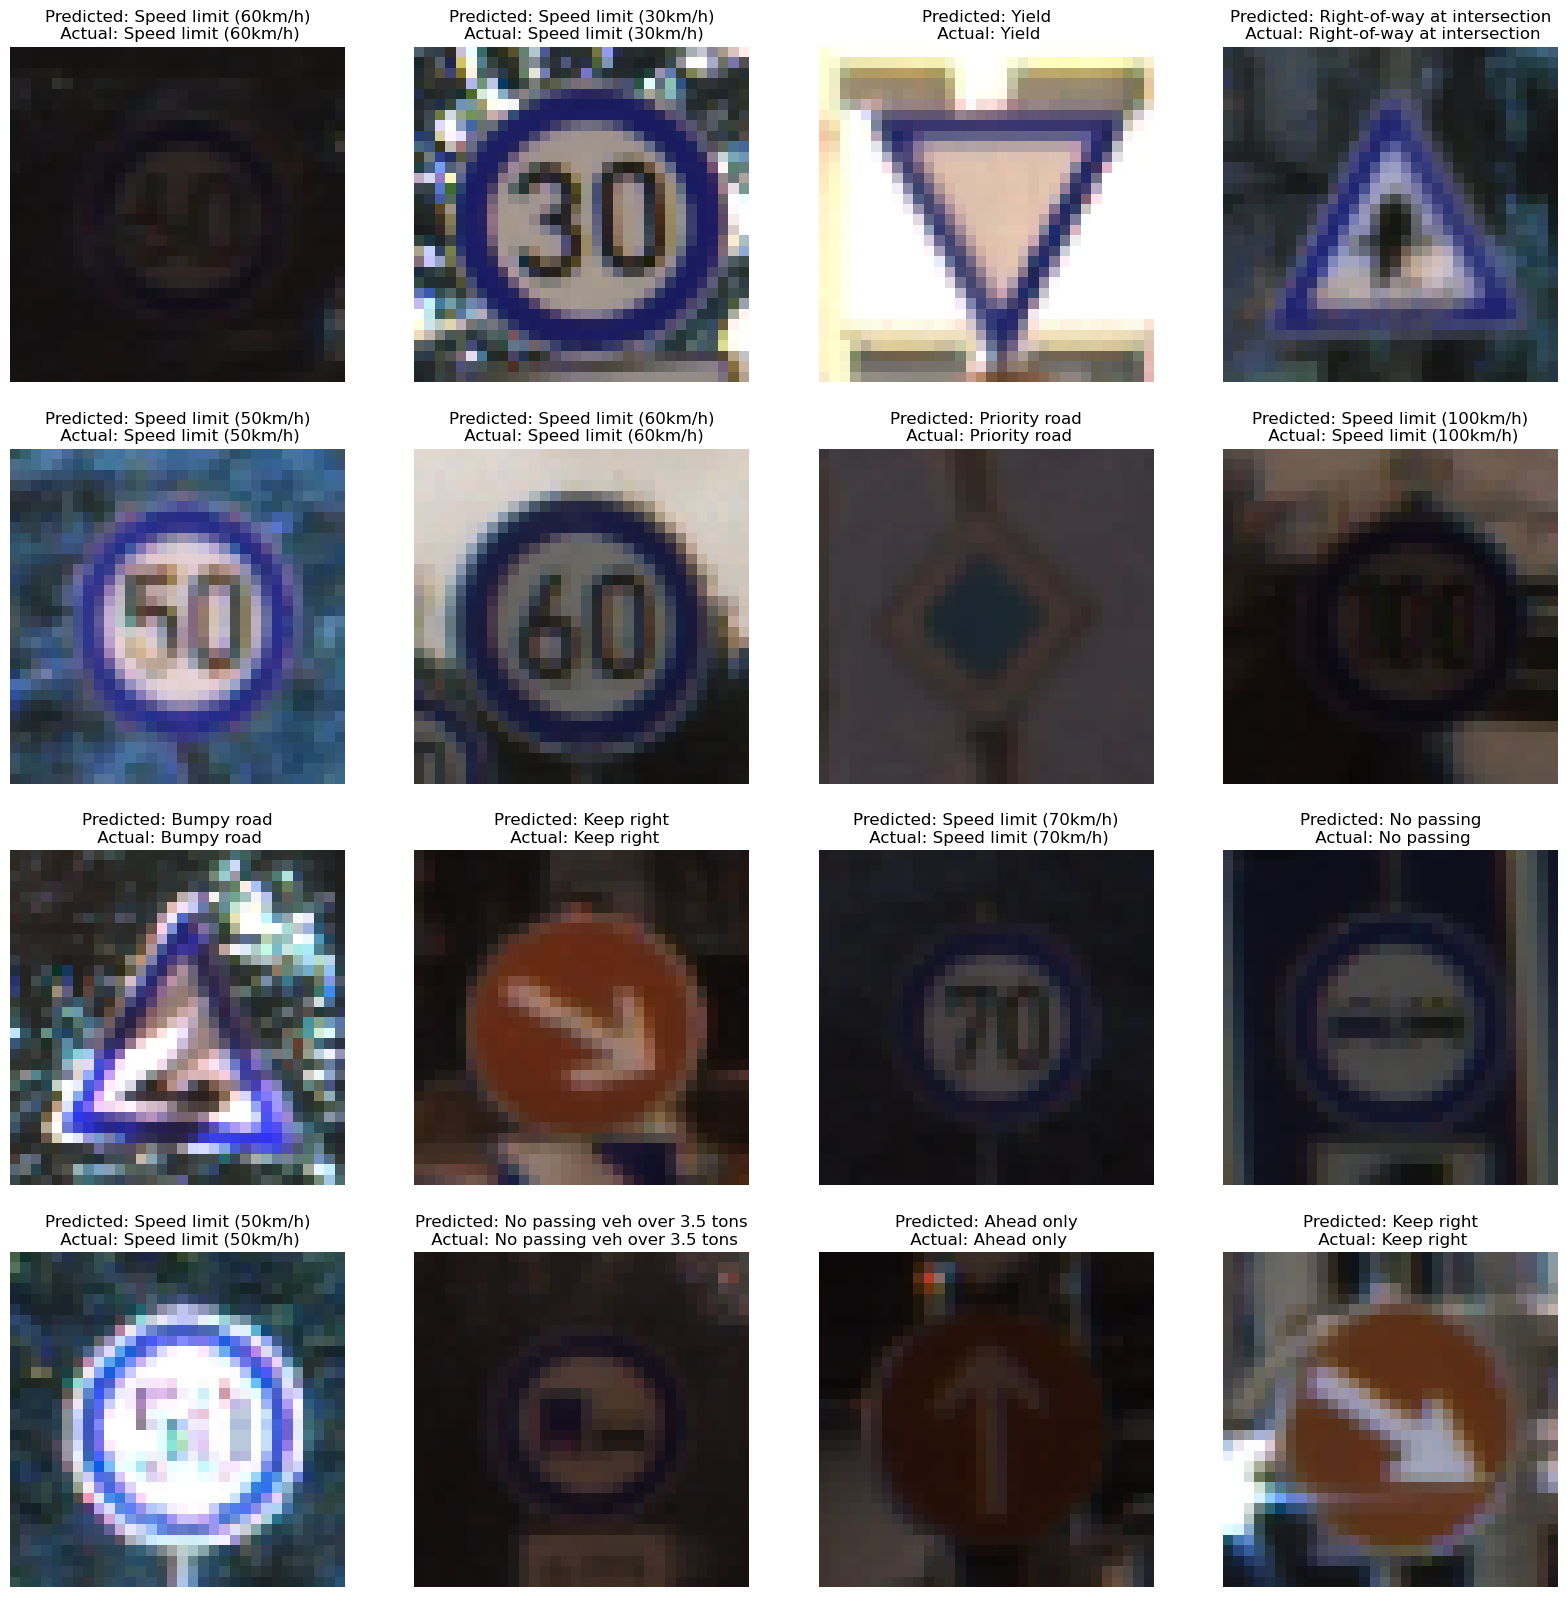

In [19]:
np.random.seed(42)
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
for i, index in enumerate(np.random.choice(true_pred, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.savefig('true_predictions_cnn.png', dpi=300)
plt.subplots_adjust(wspace=0.2)

In [20]:
false_pred = np.where(y_pred_classes != labels)[0]
print("Number of false predictions = ", len(false_pred))

Number of false predictions =  561


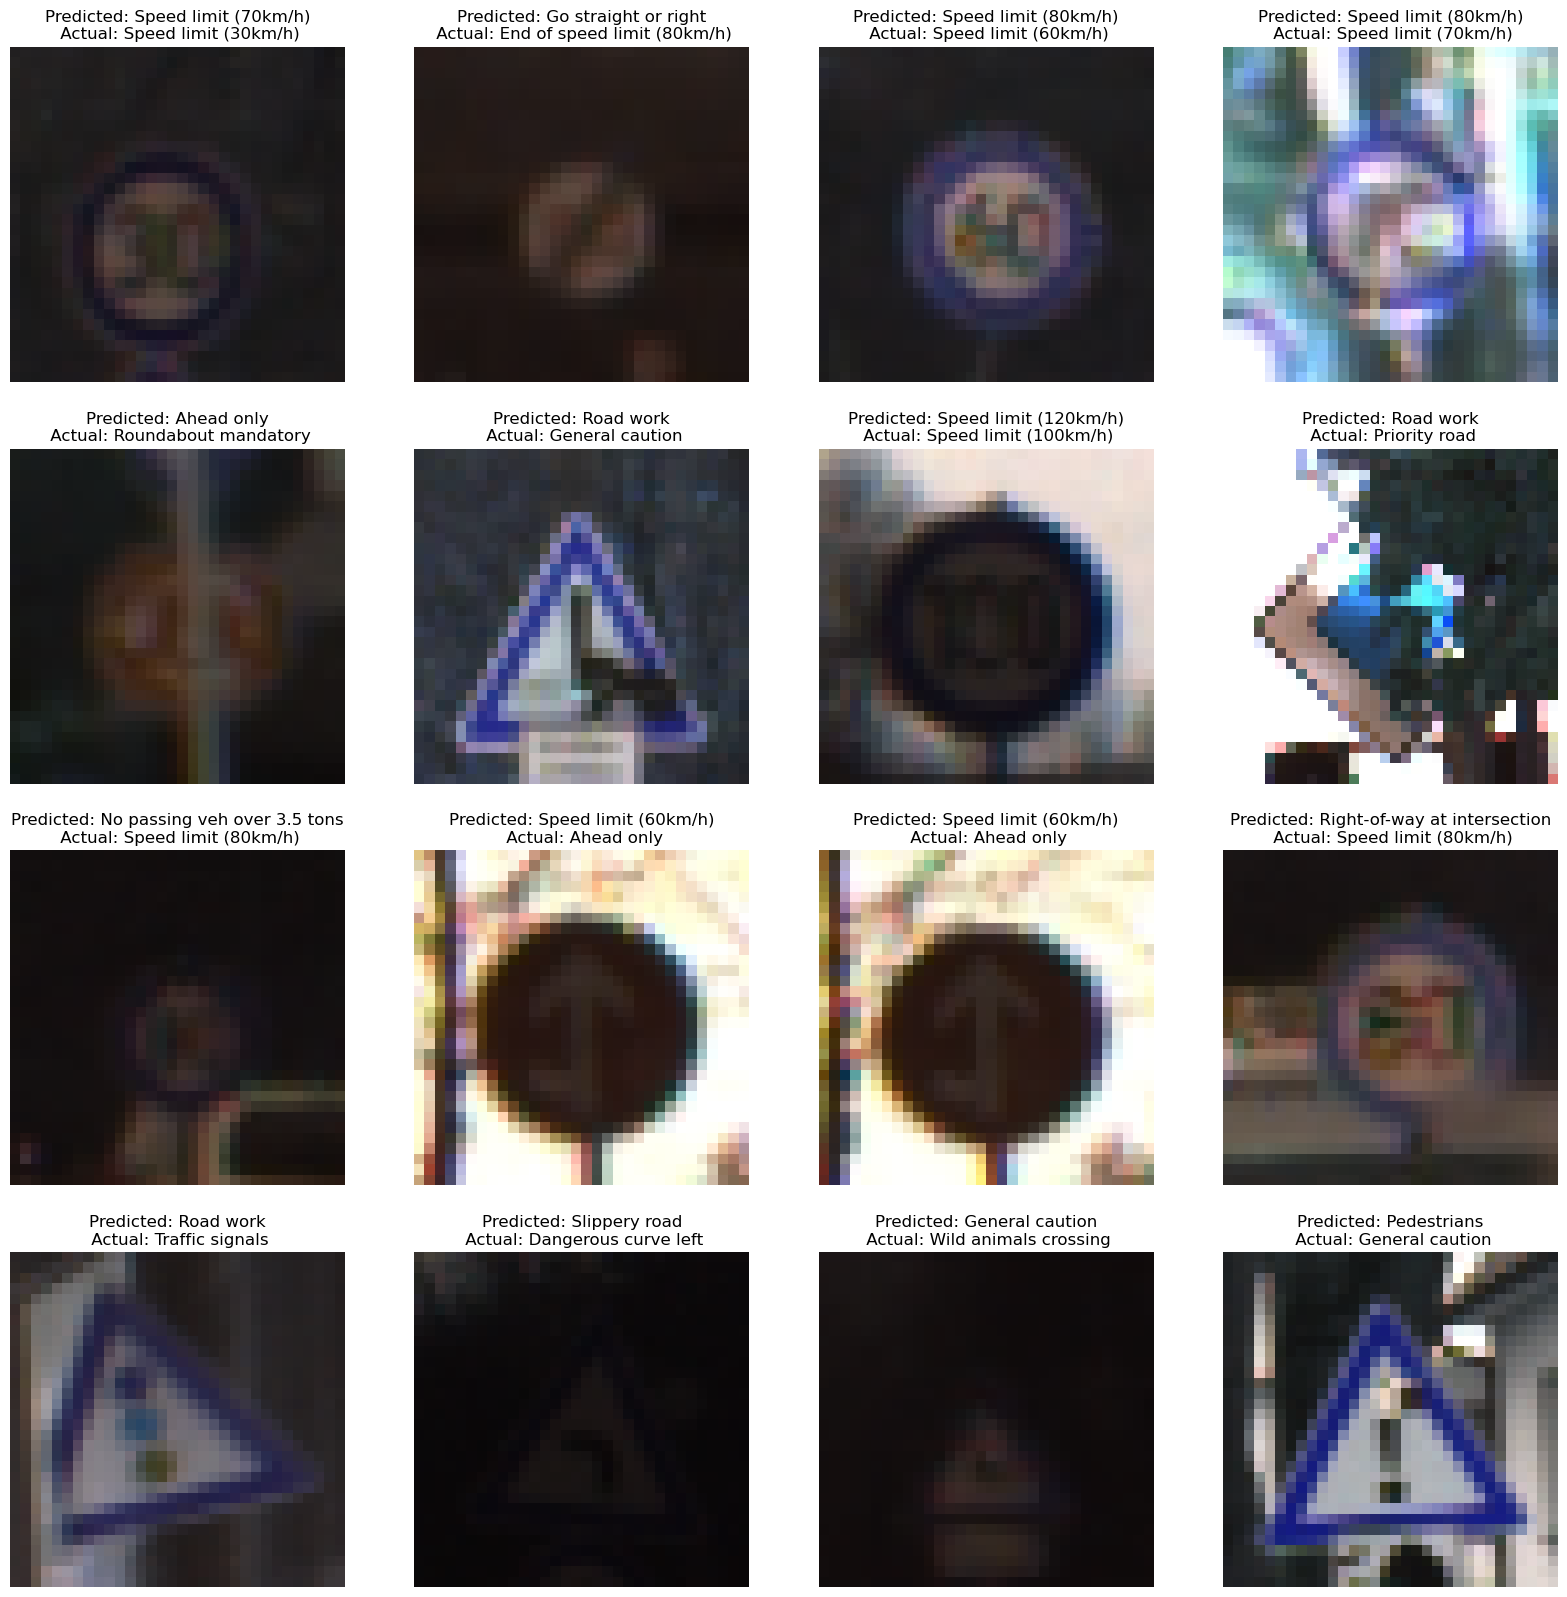

In [21]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
np.random.seed(42)
random_false_pred = np.random.choice(false_pred, 16, replace=False)
for i, index in enumerate(random_false_pred):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.savefig('false_predictions_cnn.png', dpi=300)
plt.subplots_adjust(wspace=0.2)

## HOG + SVM

In [22]:
from sklearn import svm
from skimage import color
from skimage.feature import hog

In [23]:
def load_data_hog():
    X = []
    y = []
    for path, label in zip(train_data['Path'].values.tolist(), train_data['ClassId'].values.tolist()):
        image = cv2.imread(path)
        image = preprocess_image(image)
        image = color.rgb2gray(image)
        fd = hog(image, orientations=9, pixels_per_cell=(8,8))
        X.append(fd)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train_hog, y_train_hog = load_data_hog()

In [24]:
X_train_hog

array([[0.02854935, 0.03893666, 0.03623595, ..., 0.04396983, 0.02865493,
        0.09711955],
       [0.04621418, 0.04860622, 0.01344117, ..., 0.00999707, 0.01121813,
        0.01846943],
       [0.0400166 , 0.03396483, 0.04830438, ..., 0.0440259 , 0.08161722,
        0.02300544],
       ...,
       [0.00437963, 0.        , 0.        , ..., 0.00156251, 0.00340059,
        0.0002693 ],
       [0.07590386, 0.09654893, 0.22427138, ..., 0.0125754 , 0.01797668,
        0.05122131],
       [0.05875072, 0.01944099, 0.00393965, ..., 0.01971948, 0.0068992 ,
        0.00131482]])

In [25]:
def load_data_hog_test():
    X = []
    y = []
    for path, label in zip(test_df['Path'].values.tolist(), test_df['ClassId'].values.tolist()):
        image = cv2.imread(path)
        image = preprocess_image(image)
        image = color.rgb2gray(image)
        fd = hog(image, orientations=9, pixels_per_cell=(8,8))
        X.append(fd)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_test_hog, y_test_hog = load_data_hog_test()

In [26]:
X_test_hog

array([[0.00485941, 0.01237928, 0.0316993 , ..., 0.0036549 , 0.00136943,
        0.00027301],
       [0.0567163 , 0.00507628, 0.02308017, ..., 0.00089747, 0.02397716,
        0.09432706],
       [0.01554616, 0.        , 0.        , ..., 0.00429115, 0.00255339,
        0.00220562],
       ...,
       [0.0181555 , 0.0004388 , 0.01472954, ..., 0.00128044, 0.00580129,
        0.01323133],
       [0.19086605, 0.01666074, 0.01765362, ..., 0.11096492, 0.05381471,
        0.10590259],
       [0.03785859, 0.00639554, 0.02547059, ..., 0.00449579, 0.0035733 ,
        0.0021796 ]])

In [27]:
svm = svm.SVC(kernel='linear', C=0.01)
svm.fit(X_train_hog, y_train_hog)
y_pred_svm = svm.predict(X_test_hog)
print("Accuracy: ", svm.score(X_test_hog, y_test_hog))

Accuracy:  0.572763262074426


In [28]:
true_pred_hog = np.where(y_pred_svm == y_test_hog)[0]
print("Number of true predictions = ", len(true_pred_hog))

Number of true predictions =  7234


In [29]:
false_pred_hog = np.where(y_pred_svm != y_test_hog)[0]
print("Number of false predictions = ", len(false_pred_hog))

Number of false predictions =  5396


<AxesSubplot:>

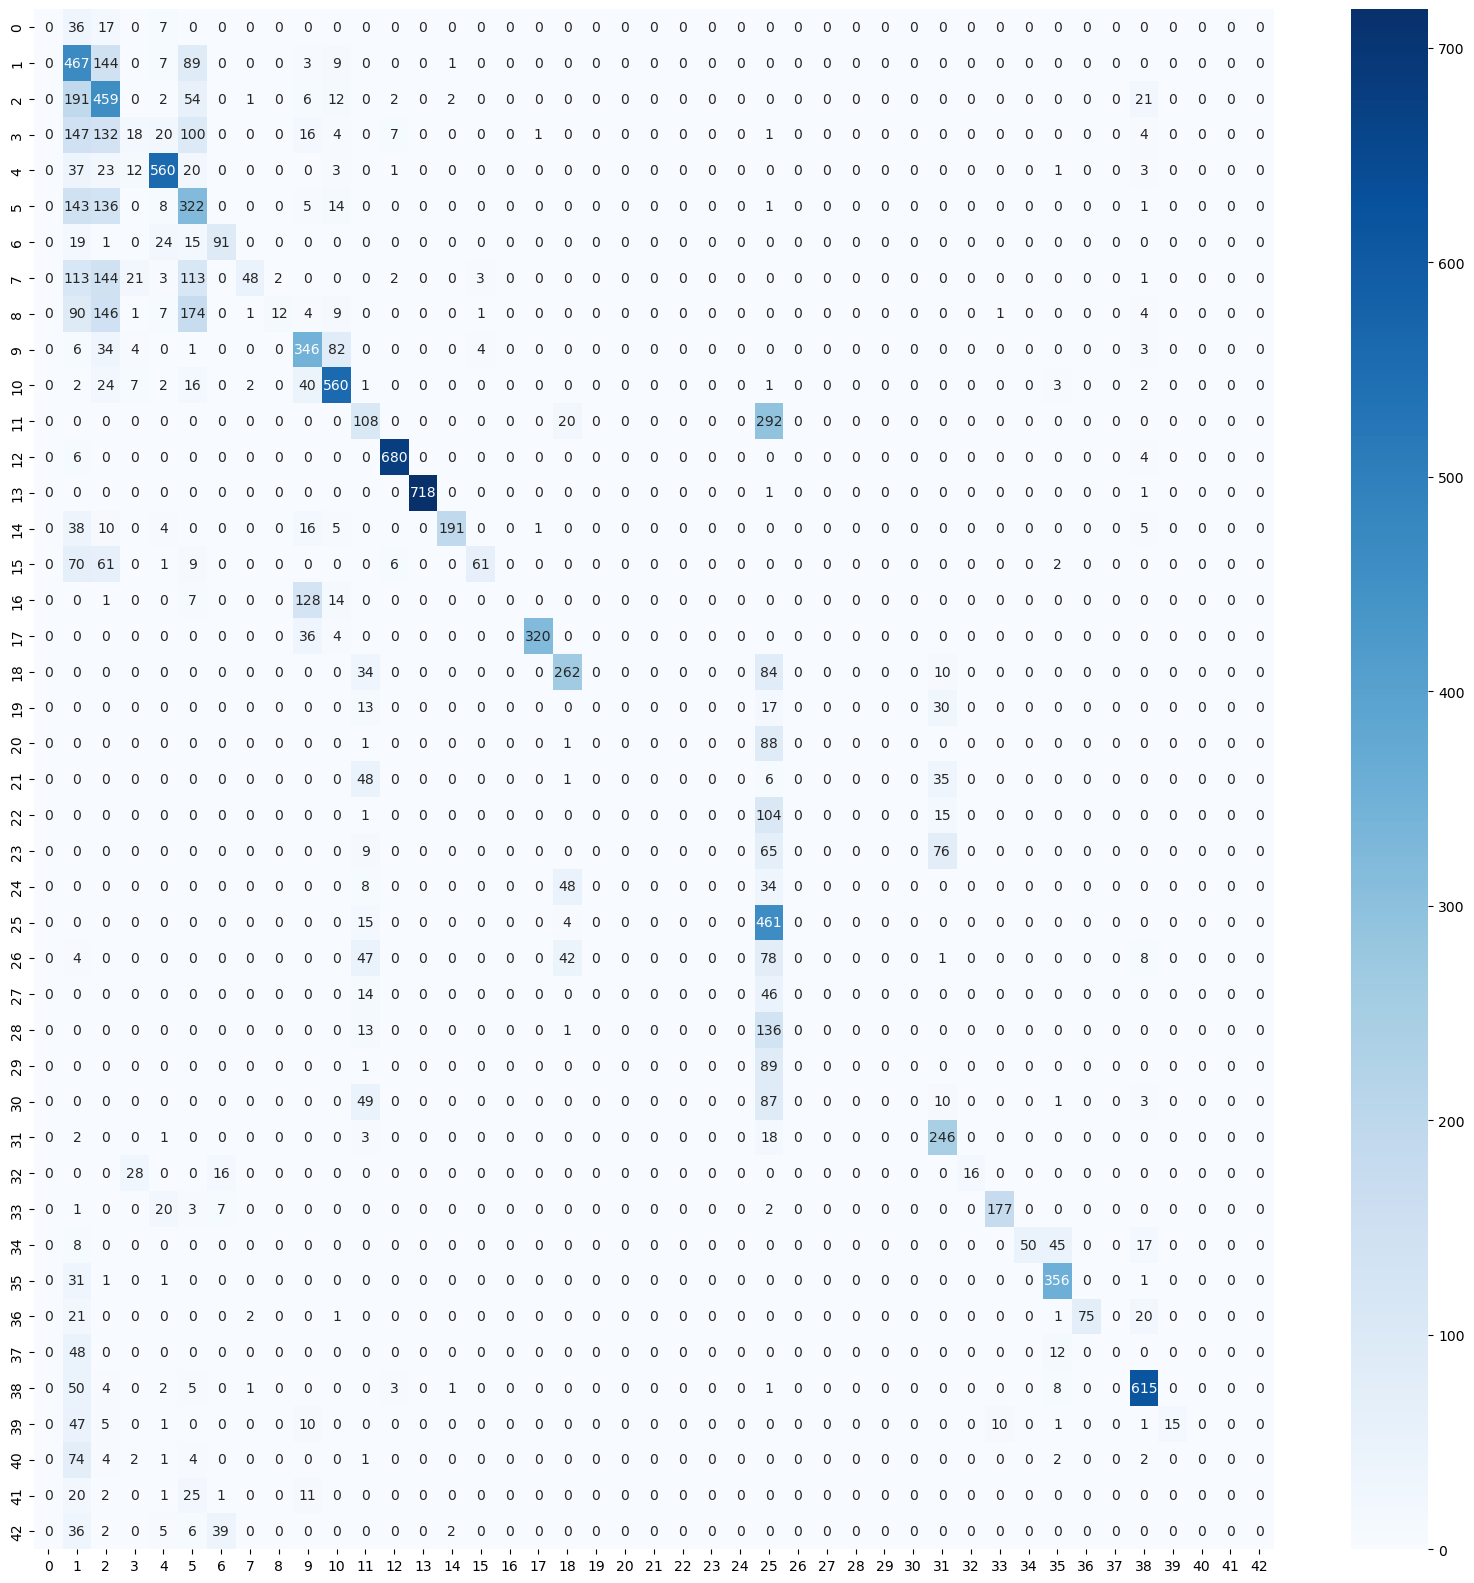

In [30]:
cm = confusion_matrix(y_test_hog, y_pred_svm)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

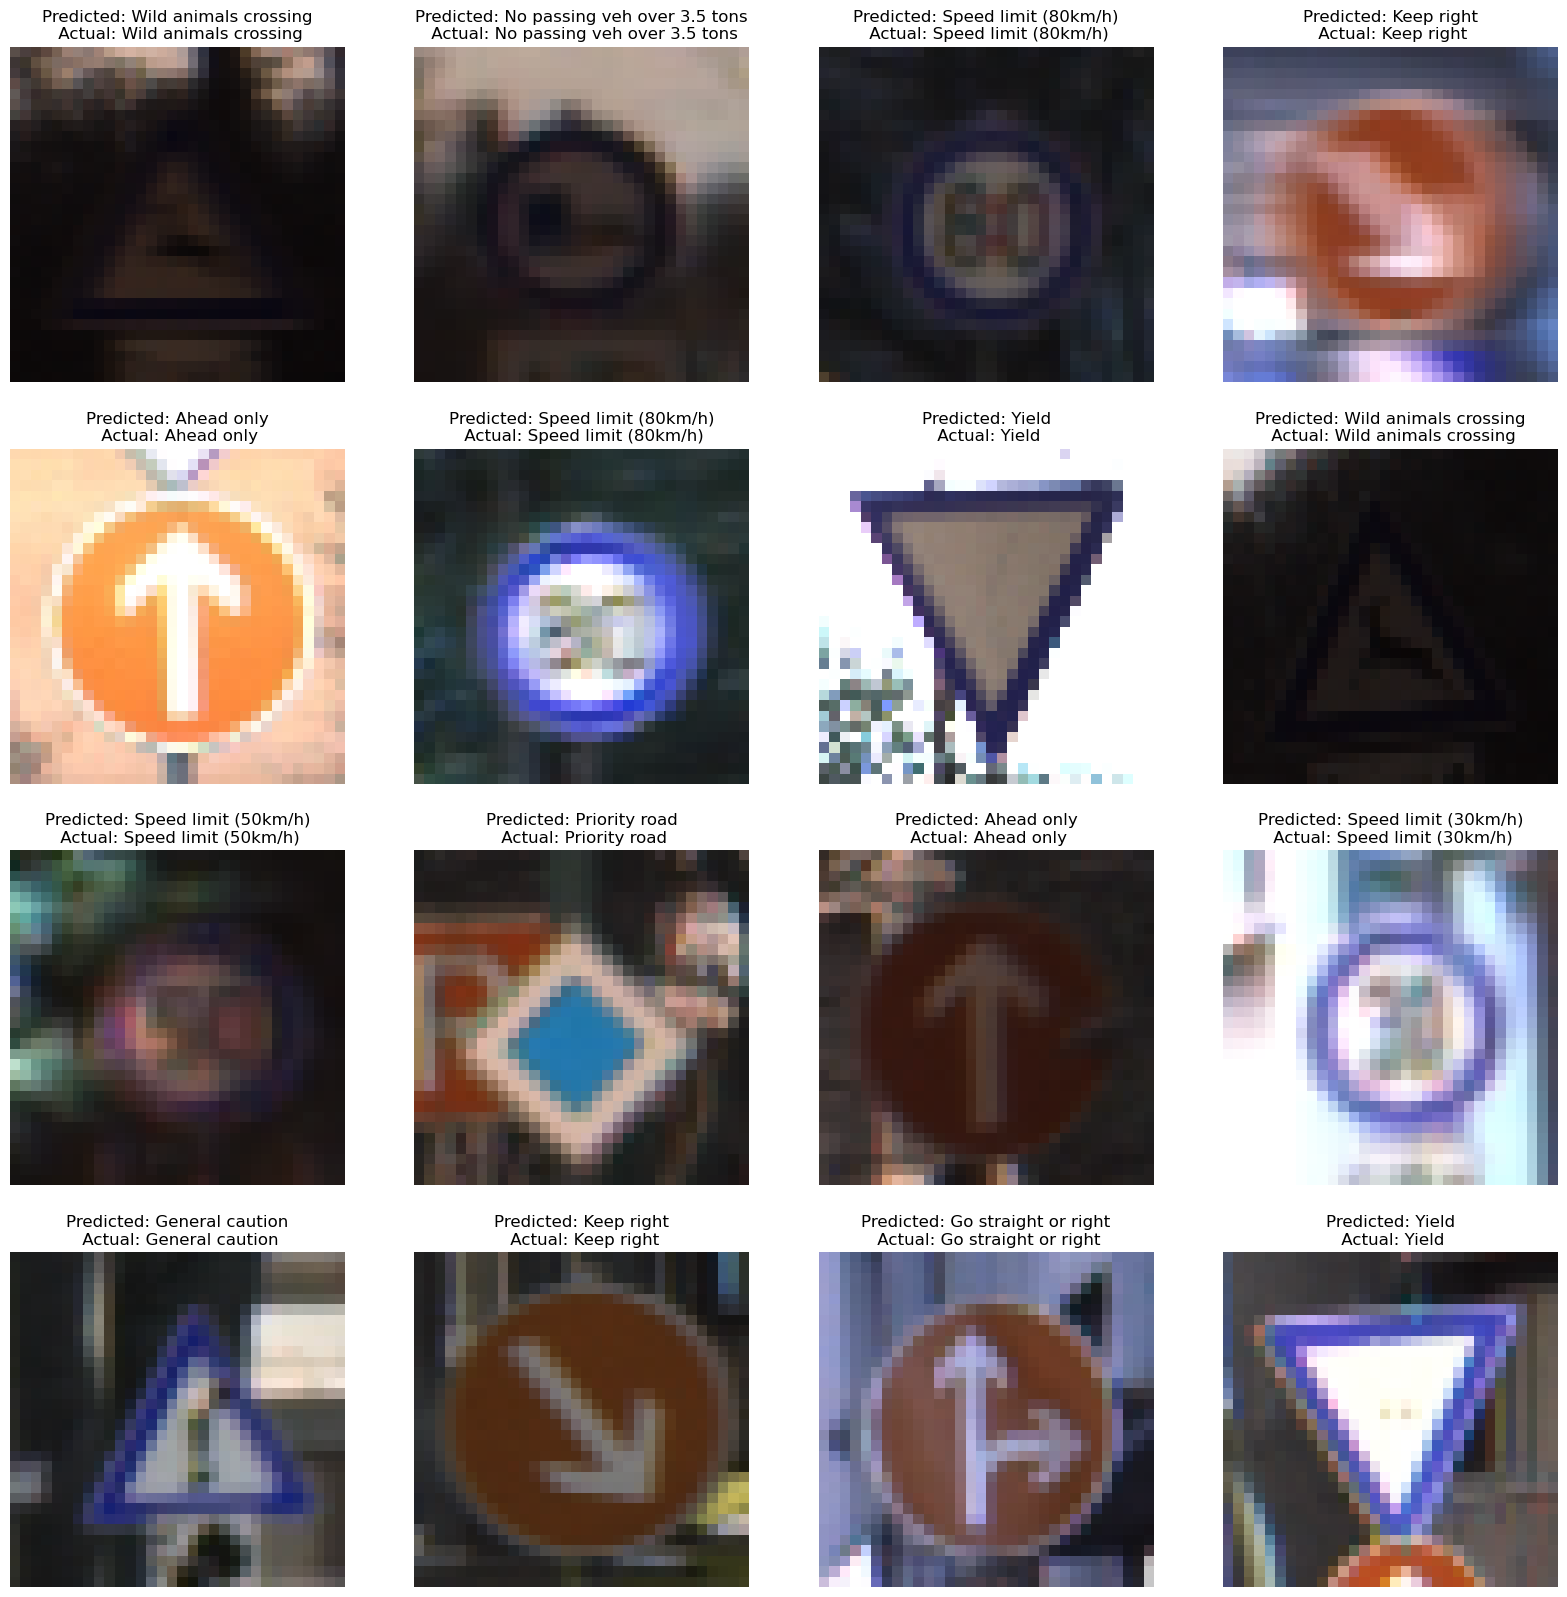

In [31]:
np.random.seed(42)
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()

for i, index in enumerate(np.random.choice(true_pred_hog, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_svm[index]]}\n Actual: {classes[y_test_hog[index]]}")
    axs[i].axis('off')
plt.savefig('true_predictions_svm.png', dpi=300)
plt.subplots_adjust(wspace=0.2)

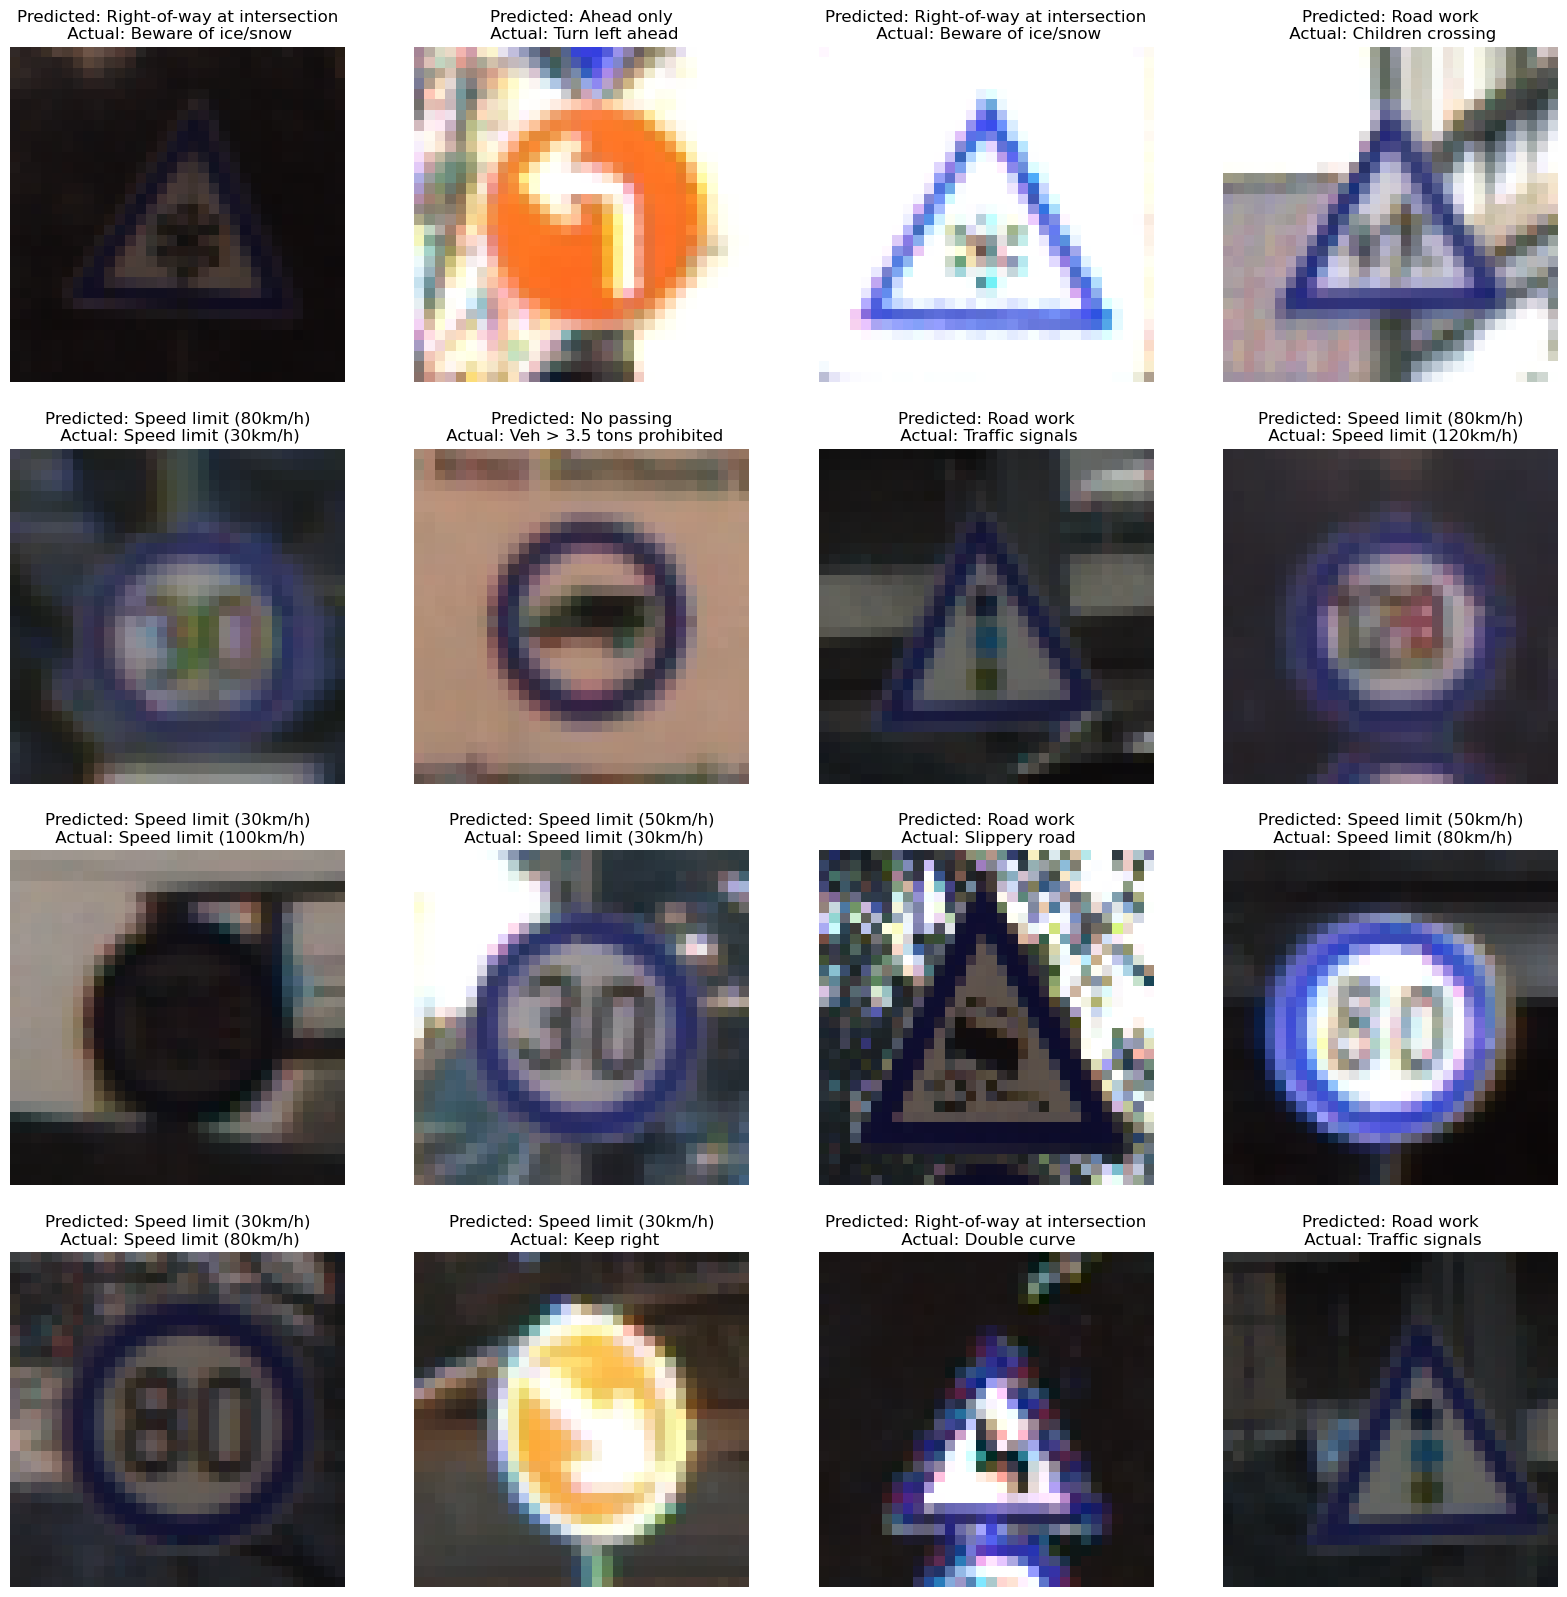

In [32]:
np.random.seed(42)
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()

for i, index in enumerate(np.random.choice(false_pred_hog, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_svm[index]]}\n Actual: {classes[y_test_hog[index]]}")
    axs[i].axis('off')
plt.savefig('false_predictions_svm.png', dpi=300)
plt.subplots_adjust(wspace=0.2)